### Neural Feature Fusion Fields: 3D Distillation of Self-Supervised 2D Image Representations
- notebook for experiments with NeRF-N3F

In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import torch
torch.set_default_tensor_type('torch.cuda.FloatTensor')

/users/vadim/.local/opt/anaconda3/envs/n3f/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import run_nerf
from run_nerf import config_parser
from vis import *
from utils import *
from run_nerf import render
import numpy as np
import matplotlib.pyplot as plt

In [4]:
dsid = 'flower'

In [5]:
parser = config_parser(f'configs/{dsid}.txt')
args = parser.parse_args()

In [7]:
args.i_weights = 1000
args.distill_active = True
args.render_only = False
args.factor = 8

In [8]:
args.dsid = dsid
args.expname = f'n3f-{dsid}'

# Train NeRF-N3F from pretrained NeRF model

In [ ]:
# checkpoint to vanilla NeRF
args.ft_path = f'logs/{dsid}_test/100000.tar'
N_iters = int(args.ft_path.split('/')[-1].split('.')[0])
state = run_nerf.train(args, N_iters=100000 + 5001)

# Load NeRF-N3F from checkpoint

In [9]:
# checkpoint to model trained with feature distillation
args.ft_path = f'logs/n3f-{dsid}/105000.tar'
state = run_nerf.train(args, N_iters=0)

Loaded image data (378, 504, 3, 34) [378.         504.         446.88232574]
Loaded ./data/nerf_llff_data/flower 22.573735200863933 222.47985705021057
recentered (3, 5)
[[ 1.0000000e+00 -1.6437306e-10  4.3859141e-10 -8.7653890e-10]
 [ 1.6437306e-10  1.0000000e+00 -3.6183792e-09 -1.1395006e-08]
 [-4.3859141e-10  3.6183792e-09  1.0000000e+00 -3.0678862e-09]]
Data:
(34, 3, 5) (34, 378, 504, 3) (34, 2)
HOLDOUT view is 20
Loaded llff (34, 378, 504, 3) (120, 3, 5) [378.      504.      446.88232] ./data/nerf_llff_data/flower
Auto LLFF holdout, 8
DEFINING BOUNDS
NEAR FAR 0.0 1.0
Found ckpts ['logs/n3f-flower/105000.tar']
Reloading from logs/n3f-flower/105000.tar
get rays


/work/vadim/workspace/experiments/rebuttal/N3F/run_nerf.py:249: UserWarning: Optimizer state dict not matched (equals strict=False).
  warnings.warn('Optimizer state dict not matched (equals strict=False).')


done, concats
shuffle rays
done
Begin
TRAIN views are [ 1  2  3  4  5  6  7  9 10 11 12 13 14 15 17 18 19 20 21 22 23 25 26 27
 28 29 30 31 33]
TEST views are [ 0  8 16 24 32]
VAL views are [ 0  8 16 24 32]


0it [00:00, ?it/s]


# Calculate query vector for selected view and patch

In [10]:
img_i = state['i_val'][0]

In [11]:
rgb, emb = render_composed(state, img_i)

/users/vadim/.local/opt/anaconda3/envs/n3f/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


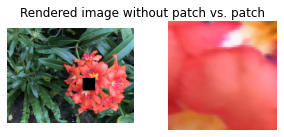

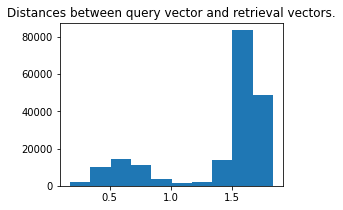

In [12]:
settings = load_settings()
r, c = settings[dsid]['rc']
extent = settings[dsid]['sz']
r = int(r * 8 / args.factor)
c = int(c * 8 / args.factor)
extent = int(extent * 8 / args.factor)

embq = calc_query_emb(emb, r, c, extent, rgb=rgb)
dist = calc_feature_dist(embq, emb)
emb_pca = calc_pca(emb)

# use histogram to get approximate threshold for decomposition
plt.figure(figsize=(4,3))
plt.hist(dist.view(-1).cpu().numpy())
plt.title('Distances between query vector and retrieval vectors.')
plt.show()

# Decomposed rendering for different view
- with query view `i`, and retrieval view `j` decomposed into rgb, rgb with foreground only (`fg`) and background only (`bg`)

In [13]:
img_j = state['i_val'][-1]
rgb_j, emb_j = render_composed(state, img_j)
rgb_j_fg, emb_j_fg = render_decomposed(
    state, img_j, embq, 
    dist_thr=settings[dsid]['thr'] + settings[dsid]['margin'], 
    foreground=True
)
rgb_j_bg, emb_j_bg = render_decomposed(
    state, img_j, embq, 
    dist_thr=settings[dsid]['thr'] - settings[dsid]['margin'], 
    foreground=False
)

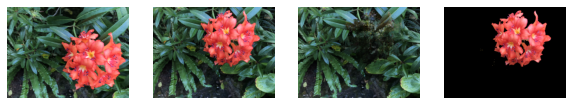

In [14]:
f, ax = plt.subplots(1, 4, figsize=(10, 5))
ax[0].imshow(rgb.cpu())
ax[0].axis('off')
ax[1].imshow(rgb_j.cpu())
ax[1].axis('off')
ax[2].imshow(rgb_j_fg.cpu())
ax[2].axis('off')
ax[3].imshow(rgb_j_bg.cpu())
ax[3].axis('off')
plt.show()

# Comparison with DINO

In [15]:
emb_dino = torch.from_numpy(state['features'][img_i])

In [16]:
embq_dino = calc_query_emb(emb_dino, r, c, extent).cpu()
dist_dino = calc_feature_dist(embq_dino, emb_dino)
emb_pca_dino = calc_pca(emb_dino)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


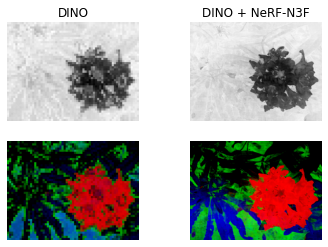

In [17]:
f, ax = plt.subplots(2, 2)
# dino
ax[0,0].imshow(dist_dino, cmap='gray')
ax[0,0].axis('off')
ax[0,0].title.set_text('DINO')
ax[1,0].imshow(emb_pca_dino)
ax[1,0].axis('off')
# dino + nerf-n3f
ax[0,1].imshow(dist, cmap='gray')
ax[0,1].axis('off')
ax[0,1].title.set_text('DINO + NeRF-N3F')
ax[1,1].imshow(emb_pca)
ax[1,1].axis('off')
plt.show()